# Install AutoGluon

In [1]:
!pip install autogluon.timeseries
!pip uninstall torchaudio torchvision torchtext -y  # fix incompatible package versions on Colab

# Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Helper Functions

In [4]:
def load_csv_intraday_prices(year):
  region = 3

  df = pd.read_csv(f'intraday-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['timestamp'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['timestamp'],
    inplace=True
  )

  return df

def intraday_prices(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_intraday_prices(year) for year in range(start, end_incl + 1)])
  df = df[~df.index.duplicated(keep='first')]
  df = df.asfreq('H')
  df = df.ffill()

  return df

In [5]:
def load_csv_total_load_forecast(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Actual Total Load [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}': 'Day-ahead Total Load Forecast [MW]' },
    inplace=True
  )

  return df

def total_load_forecast(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_forecast(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [6]:
def load_csv_total_load_actual(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Actual Total Load [MW] - BZN|SE{region}': 'Actual Total Load [MW]' },
    inplace=True
  )

  return df

def total_actual_load(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_actual(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [7]:
# SMHI files are cut to range from 2015-2023
def load_smhi(filename):
  df = pd.read_csv(filename, delimiter=';', quoting=3)
  df.index = pd.to_datetime(
    df['Datum'] + " " + df['Tid (UTC)'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['Datum', 'Tid (UTC)', 'Kvalitet'],
    inplace=True
  )

  df = df.resample('1H').asfreq()
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

## Loading in Data

In [8]:
start_year = 2019
end_year = 2023

df = intraday_prices(start=start_year, end_incl=end_year)
df.reset_index(inplace=True)

df['item_id'] = 0

df

,timestamp,vwap,item_id
0,2019-01-01 00:00:00,16.284343,0
1,2019-01-01 01:00:00,25.011842,0
2,2019-01-01 02:00:00,25.011842,0
3,2019-01-01 03:00:00,25.011842,0
4,2019-01-01 04:00:00,25.011842,0
...,...,...,...
43819,2023-12-31 19:00:00,45.826785,0
43820,2023-12-31 20:00:00,34.628882,0
43821,2023-12-31 21:00:00,29.144728,0
43822,2023-12-31 22:00:00,24.143971,0


## Mirror Logarithm

In [9]:
def mlog(df, c=1/3):
  return np.sign(df) * (np.log(1 / c + np.abs(df)) + np.log(c))

def mlog_inv(df, c=1/3):
  return np.sign(df) * (np.exp(np.abs(df) - np.log(c)) - 1 / c)

In [10]:
df['vwap_log'] = mlog(df['vwap'])
df.drop(columns=['vwap'], inplace=True)
df

,timestamp,item_id,vwap_log
0,2019-01-01 00:00:00,0,1.860681
1,2019-01-01 01:00:00,0,2.234015
2,2019-01-01 02:00:00,0,2.234015
3,2019-01-01 03:00:00,0,2.234015
4,2019-01-01 04:00:00,0,2.234015
...,...,...,...
43819,2023-12-31 19:00:00,0,2.789667
43820,2023-12-31 20:00:00,0,2.529160
43821,2023-12-31 21:00:00,0,2.371636
43822,2023-12-31 22:00:00,0,2.202543


# Covariates

In [11]:
actual_load = total_actual_load(start=start_year, end_incl=end_year).reset_index()
predicted_load = total_load_forecast(start=start_year, end_incl=end_year).reset_index()

df['Actual Load'] = actual_load['Actual Total Load [MW]']
df['Predicted Load'] = predicted_load['Day-ahead Total Load Forecast [MW]']

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load
0,2019-01-01 00:00:00,0,1.860681,9212.0,9167.0
1,2019-01-01 01:00:00,0,2.234015,9057.0,8968.0
2,2019-01-01 02:00:00,0,2.234015,8949.0,8759.0
3,2019-01-01 03:00:00,0,2.234015,8812.0,8635.0
4,2019-01-01 04:00:00,0,2.234015,8804.0,8549.0
...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,2.789667,11947.0,11877.0
43820,2023-12-31 20:00:00,0,2.529160,11561.0,11563.0
43821,2023-12-31 21:00:00,0,2.371636,11276.0,11350.0
43822,2023-12-31 22:00:00,0,2.202543,11035.0,11099.0


In [12]:
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['hour'] = df['timestamp'].dt.hour

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load,month,weekday,hour
0,2019-01-01 00:00:00,0,1.860681,9212.0,9167.0,1,1,0
1,2019-01-01 01:00:00,0,2.234015,9057.0,8968.0,1,1,1
2,2019-01-01 02:00:00,0,2.234015,8949.0,8759.0,1,1,2
3,2019-01-01 03:00:00,0,2.234015,8812.0,8635.0,1,1,3
4,2019-01-01 04:00:00,0,2.234015,8804.0,8549.0,1,1,4
...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,2.789667,11947.0,11877.0,12,6,19
43820,2023-12-31 20:00:00,0,2.529160,11561.0,11563.0,12,6,20
43821,2023-12-31 21:00:00,0,2.371636,11276.0,11350.0,12,6,21
43822,2023-12-31 22:00:00,0,2.202543,11035.0,11099.0,12,6,22


In [13]:
solar_df = load_smhi('smhi-solar-radiation-stockholmsol.csv').reset_index()
temperature_df = load_smhi('smhi-temperature-bma.csv').reset_index()
windspeed_df = load_smhi('smhi-windspeed-bma.csv').drop(columns=['Vindriktning', 'Kvalitet.1']).reset_index()

df['Solar Radiation'] = solar_df.loc[solar_df['index'] >= f'{start_year}-01-01']['Global Irradians'].values
df['Temperature'] = temperature_df.loc[temperature_df['index'] >= f'{start_year}-01-01']['Lufttemperatur'].values
df['Windspeed'] = windspeed_df.loc[windspeed_df['index'] >= f'{start_year}-01-01']['Vindhastighet'].values

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2019-01-01 00:00:00,0,1.860681,9212.0,9167.0,1,1,0,0.0,4.2,3.0
1,2019-01-01 01:00:00,0,2.234015,9057.0,8968.0,1,1,1,0.0,5.6,5.0
2,2019-01-01 02:00:00,0,2.234015,8949.0,8759.0,1,1,2,0.0,6.2,6.0
3,2019-01-01 03:00:00,0,2.234015,8812.0,8635.0,1,1,3,0.0,6.6,6.0
4,2019-01-01 04:00:00,0,2.234015,8804.0,8549.0,1,1,4,0.0,5.8,3.0
...,...,...,...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,2.789667,11947.0,11877.0,12,6,19,0.0,-2.4,4.0
43820,2023-12-31 20:00:00,0,2.529160,11561.0,11563.0,12,6,20,0.0,-2.3,3.0
43821,2023-12-31 21:00:00,0,2.371636,11276.0,11350.0,12,6,21,0.0,-2.3,4.0
43822,2023-12-31 22:00:00,0,2.202543,11035.0,11099.0,12,6,22,0.0,-2.1,3.0


## Scaling down

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['vwap_log']] = scaler.fit_transform(df[['vwap_log']])
df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']] = MinMaxScaler().fit_transform(df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']])

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2019-01-01 00:00:00,0,0.562776,0.370550,0.344278,1,1,0,0.0,0.438976,0.250000
1,2019-01-01 01:00:00,0,0.607406,0.357597,0.327307,1,1,1,0.0,0.466535,0.416667
2,2019-01-01 02:00:00,0,0.607406,0.348571,0.309483,1,1,2,0.0,0.478346,0.500000
3,2019-01-01 03:00:00,0,0.607406,0.337122,0.298908,1,1,3,0.0,0.486220,0.500000
4,2019-01-01 04:00:00,0,0.607406,0.336453,0.291574,1,1,4,0.0,0.470472,0.250000
...,...,...,...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,0.673833,0.599114,0.575388,12,6,19,0.0,0.309055,0.333333
43820,2023-12-31 20:00:00,0,0.642690,0.566856,0.548610,12,6,20,0.0,0.311024,0.250000
43821,2023-12-31 21:00:00,0,0.623859,0.543039,0.530445,12,6,21,0.0,0.311024,0.333333
43822,2023-12-31 22:00:00,0,0.603644,0.522898,0.509040,12,6,22,0.0,0.314961,0.250000


# Create the AutoGluon Timeseries

In [15]:
series = TimeSeriesDataFrame.from_data_frame(
  df,
  id_column='item_id',
  timestamp_column='timestamp'
)

series['month'] = series['month'].astype('category')
series['weekday'] = series['weekday'].astype('category')
series['hour'] = series['hour'].astype('category')

series.head()

vwap_log  Actual Load  Predicted Load month  \
item_id timestamp                                                          
0       2019-01-01 00:00:00  0.562776     0.370550        0.344278     1   
        2019-01-01 01:00:00  0.607406     0.357597        0.327307     1   
        2019-01-01 02:00:00  0.607406     0.348571        0.309483     1   
        2019-01-01 03:00:00  0.607406     0.337122        0.298908     1   
        2019-01-01 04:00:00  0.607406     0.336453        0.291574     1   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2019-01-01 00:00:00       1    0              0.0     0.438976   
        2019-01-01 01:00:00       1    1              0.0     0.466535   
        2019-01-01 02:00:00       1    2              0.0     0.478346   
        2019-01-01 03:00:00       1    3              0.0     0.486220   
        2019-01-01 04:00:00       1    4              0.0     0.470472   

                             Windspeed  
item_id timestamp                       
0       2019-01-01 00:00:00   0.250000  
        2019-01-01 01:00:00   0.416667  
        2019-01-01 02:00:00   0.500000  
        2019-01-01 03:00:00   0.500000  
        2019-01-01 04:00:00   0.250000

In [16]:
cutoff = pd.Timestamp(f'{end_year}-01-01')
train, test = series.split_by_time(cutoff)

train

vwap_log  Actual Load  Predicted Load month  \
item_id timestamp                                                          
0       2019-01-01 00:00:00  0.562776     0.370550        0.344278     1   
        2019-01-01 01:00:00  0.607406     0.357597        0.327307     1   
        2019-01-01 02:00:00  0.607406     0.348571        0.309483     1   
        2019-01-01 03:00:00  0.607406     0.337122        0.298908     1   
        2019-01-01 04:00:00  0.607406     0.336453        0.291574     1   
...                               ...          ...             ...   ...   
        2022-12-31 19:00:00  0.559971     0.441083        0.427341    12   
        2022-12-31 20:00:00  0.550721     0.403142        0.394764    12   
        2022-12-31 21:00:00  0.557048     0.373809        0.371823    12   
        2022-12-31 22:00:00  0.533112     0.360521        0.356899    12   
        2022-12-31 23:00:00  0.484172     0.348153        0.340525    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2019-01-01 00:00:00       1    0              0.0     0.438976   
        2019-01-01 01:00:00       1    1              0.0     0.466535   
        2019-01-01 02:00:00       1    2              0.0     0.478346   
        2019-01-01 03:00:00       1    3              0.0     0.486220   
        2019-01-01 04:00:00       1    4              0.0     0.470472   
...                             ...  ...              ...          ...   
        2022-12-31 19:00:00       5   19              0.0     0.478346   
        2022-12-31 20:00:00       5   20              0.0     0.466535   
        2022-12-31 21:00:00       5   21              0.0     0.452756   
        2022-12-31 22:00:00       5   22              0.0     0.444882   
        2022-12-31 23:00:00       5   23              0.0     0.423228   

                             Windspeed  
item_id timestamp                       
0       2019-01-01 00:00:00   0.250000  
        2019-01-01 01:00:00   0.416667  
        2019-01-01 02:00:00   0.500000  
        2019-01-01 03:00:00   0.500000  
        2019-01-01 04:00:00   0.250000  
...                                ...  
        2022-12-31 19:00:00   0.333333  
        2022-12-31 20:00:00   0.250000  
        2022-12-31 21:00:00   0.250000  
        2022-12-31 22:00:00   0.333333  
        2022-12-31 23:00:00   0.250000  

[35064 rows x 9 columns]

In [17]:
test

vwap_log  Actual Load  Predicted Load month  \
item_id timestamp                                                          
0       2023-01-01 00:00:00  0.396087     0.349072        0.328927     1   
        2023-01-01 01:00:00  0.298902     0.348070        0.321252     1   
        2023-01-01 02:00:00  0.264610     0.346900        0.316050     1   
        2023-01-01 03:00:00  0.248917     0.343390        0.311189     1   
        2023-01-01 04:00:00  0.279139     0.341050        0.313491     1   
...                               ...          ...             ...   ...   
        2023-12-31 19:00:00  0.673833     0.599114        0.575388    12   
        2023-12-31 20:00:00  0.642690     0.566856        0.548610    12   
        2023-12-31 21:00:00  0.623859     0.543039        0.530445    12   
        2023-12-31 22:00:00  0.603644     0.522898        0.509040    12   
        2023-12-31 23:00:00  0.591116     0.505850        0.490960    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2023-01-01 00:00:00       6    0              0.0     0.413386   
        2023-01-01 01:00:00       6    1              0.0     0.405512   
        2023-01-01 02:00:00       6    2              0.0     0.385827   
        2023-01-01 03:00:00       6    3              0.0     0.374016   
        2023-01-01 04:00:00       6    4              0.0     0.354331   
...                             ...  ...              ...          ...   
        2023-12-31 19:00:00       6   19              0.0     0.309055   
        2023-12-31 20:00:00       6   20              0.0     0.311024   
        2023-12-31 21:00:00       6   21              0.0     0.311024   
        2023-12-31 22:00:00       6   22              0.0     0.314961   
        2023-12-31 23:00:00       6   23              0.0     0.316929   

                             Windspeed  
item_id timestamp                       
0       2023-01-01 00:00:00   0.166667  
        2023-01-01 01:00:00   0.166667  
        2023-01-01 02:00:00   0.083333  
        2023-01-01 03:00:00   0.083333  
        2023-01-01 04:00:00   0.083333  
...                                ...  
        2023-12-31 19:00:00   0.333333  
        2023-12-31 20:00:00   0.250000  
        2023-12-31 21:00:00   0.333333  
        2023-12-31 22:00:00   0.250000  
        2023-12-31 23:00:00   0.333333  

[8760 rows x 9 columns]

# Model Creation

In [18]:
predictor = TimeSeriesPredictor(
  prediction_length=24,
  freq="H",
  path="autogluon-intraday",
  target="vwap_log",
  eval_metric="MSE",
)

predictor.fit(
  train,
  num_val_windows=120,
  refit_every_n_windows=None,
  val_step_size=72,
  presets="high_quality",
  time_limit=1500,
)

Beginning AutoGluon training... Time limit = 1500s
AutoGluon will save models to 'autogluon-intraday'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
GPU Count:          1
Memory Avail:       11.59 GB / 12.67 GB (91.4%)
Disk Space Avail:   45.73 GB / 78.19 GB (58.5%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'H',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 120,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'vwap_log',
 'time_limit': 1500,
 'val_step_size': 72,
 'verbosity': 2}

Provided train_data has 35064 rows, 1 time series. Median time series

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.0087       = Validation score (-MSE)
	115.73  s     = Training runtime
	0.83    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 186.2s of the 745.0s of remaining time.
	-0.0115       = Validation score (-MSE)
	179.91  s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 188.3s of the 564.9s of remaining time.
	-0.0088       = Validation score (-MSE)
	165.36  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 199.7s of the 399.4s of remaining time.
	-0.0099       = Validation score (-MSE)
	51.47   s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[base]': 0.39, 'CrostonSBA': 0.02, 'DeepAR': 0.16, 'DirectTabular': 0.17, 'NPTS': 0.02, 'PatchTST': 0.02, 'RecursiveTabular': 0.21}
	-0.0077  

# Prediction Time

In [19]:
history = series.slice_by_time(pd.Timestamp(f'{end_year - 1}-12-30'), pd.Timestamp(f'{end_year}-01-01'))
prediction = predictor.predict(history, model='WeightedEnsemble')
prediction

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2023-01-01 00:00:00  0.453435  0.415901  0.427046  0.436506  0.448226   
        2023-01-01 01:00:00  0.417547  0.359634  0.387714  0.398060  0.406823   
        2023-01-01 02:00:00  0.405060  0.341662  0.366866  0.378086  0.384692   
        2023-01-01 03:00:00  0.391376  0.322966  0.342970  0.360578  0.379841   
        2023-01-01 04:00:00  0.393136  0.305434  0.355660  0.371635  0.383138   
        2023-01-01 05:00:00  0.438703  0.354896  0.388830  0.409081  0.422591   
        2023-01-01 06:00:00  0.467416  0.380130  0.402703  0.422395  0.442569   
        2023-01-01 07:00:00  0.465500  0.354668  0.393450  0.421014  0.449937   
        2023-01-01 08:00:00  0.462608  0.341027  0.388413  0.412465  0.445624   
        2023-01-01 09:00:00  0.483336  0.373207  0.404146  0.445230  0.475739   
        2023-01-01 10:00:00  0.518128  0.403352  0.443191  0.490061  0.509126   
        2023-01-01 11:00:00  0.527762  0.406643  0.470768  0.494596  0.516101   
        2023-01-01 12:00:00  0.540490  0.432173  0.485289  0.508703  0.531351   
        2023-01-01 13:00:00  0.554963  0.470409  0.503250  0.520037  0.534106   
        2023-01-01 14:00:00  0.563825  0.476488  0.510365  0.531392  0.549887   
        2023-01-01 15:00:00  0.571101  0.483478  0.514476  0.540269  0.561015   
        2023-01-01 16:00:00  0.583832  0.495098  0.525836  0.555934  0.573871   
        2023-01-01 17:00:00  0.579633  0.491566  0.521210  0.547676  0.566051   
        2023-01-01 18:00:00  0.575038  0.478327  0.519123  0.544741  0.560871   
        2023-01-01 19:00:00  0.559367  0.450975  0.496723  0.518108  0.554324   
        2023-01-01 20:00:00  0.550048  0.450064  0.479722  0.509920  0.535059   
        2023-01-01 21:00:00  0.540044  0.444371  0.470649  0.501474  0.527966   
        2023-01-01 22:00:00  0.520555  0.423402  0.453735  0.479311  0.495981   
        2023-01-01 23:00:00  0.481040  0.377301  0.407126  0.441053  0.461200   

                                  0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                              
0       2023-01-01 00:00:00  0.453115  0.458875  0.467700  0.476738  0.493078  
        2023-01-01 01:00:00  0.414773  0.429669  0.439814  0.451497  0.466056  
        2023-01-01 02:00:00  0.402324  0.418388  0.431712  0.447090  0.476180  
        2023-01-01 03:00:00  0.390716  0.407262  0.419282  0.437393  0.461198  
        2023-01-01 04:00:00  0.392919  0.407765  0.428766  0.448076  0.464776  
        2023-01-01 05:00:00  0.437581  0.462850  0.475276  0.501669  0.522424  
        2023-01-01 06:00:00  0.468809  0.493221  0.523959  0.537511  0.558607  
        2023-01-01 07:00:00  0.467856  0.484798  0.515308  0.548826  0.567308  
        2023-01-01 08:00:00  0.470894  0.503790  0.515789  0.535229  0.559752  
        2023-01-01 09:00:00  0.494128  0.519100  0.531706  0.553408  0.575071  
        2023-01-01 10:00:00  0.526632  0.553410  0.566870  0.584987  0.606116  
        2023-01-01 11:00:00  0.535986  0.557301  0.574787  0.594853  0.616909  
        2023-01-01 12:00:00  0.548604  0.562944  0.584452  0.606434  0.631358  
        2023-01-01 13:00:00  0.558017  0.581053  0.600028  0.618871  0.640758  
        2023-01-01 14:00:00  0.563691  0.583225  0.604207  0.632368  0.654133  
        2023-01-01 15:00:00  0.572413  0.589017  0.611322  0.640739  0.659788  
        2023-01-01 16:00:00  0.585264  0.601809  0.624895  0.647128  0.673826  
        2023-01-01 17:00:00  0.583697  0.600827  0.618710  0.645910  0.670324  
        2023-01-01 18:00:00  0.583304  0.597498  0.613222  0.634741  0.668503  
        2023-01-01 19:00:00  0.567705  0.586763  0.599816  0.621869  0.659335  
        2023-01-01 20:00:00  0.551537  0.571045  0.593511  0.617869  0.646730  
        2023-01-01 21:00:00  0.542275  0.555692  0.577333  0.602772  0.636667  
      

## Predicting the Test Set

In [20]:
forecasts = []

for day in pd.date_range(f'{end_year}-01-01', f'{end_year}-12-31'):
  print(f'Forecasting day {day.strftime("%Y-%m-%d")}')
  history = series.slice_by_time(day - pd.DateOffset(days=2), day)
  forecast = predictor.predict(history, model='WeightedEnsemble')
  forecasts.append(forecast)

forecasts = pd.concat(forecasts)

Forecasting day 2023-01-01
Forecasting day 2023-01-02
Forecasting day 2023-01-03
Forecasting day 2023-01-04
Forecasting day 2023-01-05
Forecasting day 2023-01-06
Forecasting day 2023-01-07
Forecasting day 2023-01-08
Forecasting day 2023-01-09
Forecasting day 2023-01-10
Forecasting day 2023-01-11
Forecasting day 2023-01-12
Forecasting day 2023-01-13
Forecasting day 2023-01-14
Forecasting day 2023-01-15
Forecasting day 2023-01-16
Forecasting day 2023-01-17
Forecasting day 2023-01-18
Forecasting day 2023-01-19
Forecasting day 2023-01-20
Forecasting day 2023-01-21
Forecasting day 2023-01-22
Forecasting day 2023-01-23
Forecasting day 2023-01-24
Forecasting day 2023-01-25
Forecasting day 2023-01-26
Forecasting day 2023-01-27
Forecasting day 2023-01-28
Forecasting day 2023-01-29
Forecasting day 2023-01-30
Forecasting day 2023-01-31
Forecasting day 2023-02-01
Forecasting day 2023-02-02
Forecasting day 2023-02-03
Forecasting day 2023-02-04
Forecasting day 2023-02-05
Forecasting day 2023-02-06
F

Looks promising!

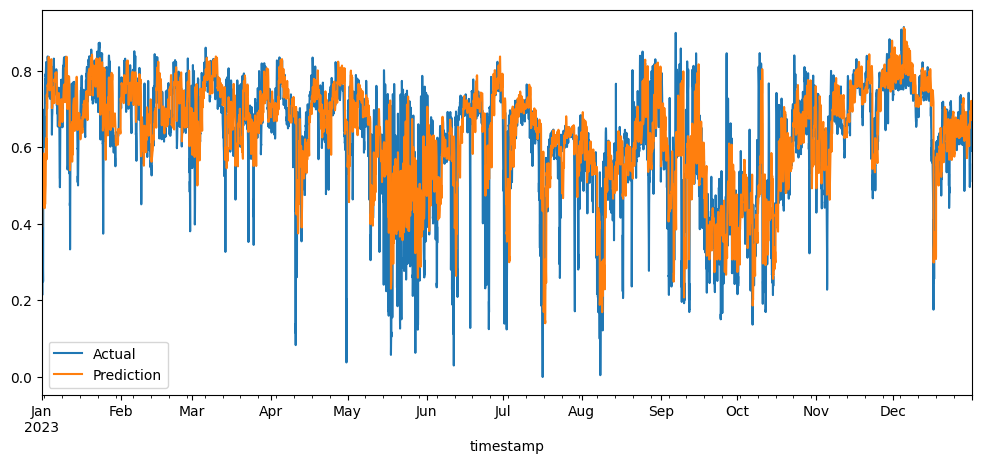

In [22]:
plt.figure(figsize=(12, 5))
test.loc[0]['vwap_log'].plot(label='Actual')
forecasts.loc[0]['mean'].plot(label='Prediction')
plt.legend()

## Zooming in on a Month

(466008.0, 466752.0)

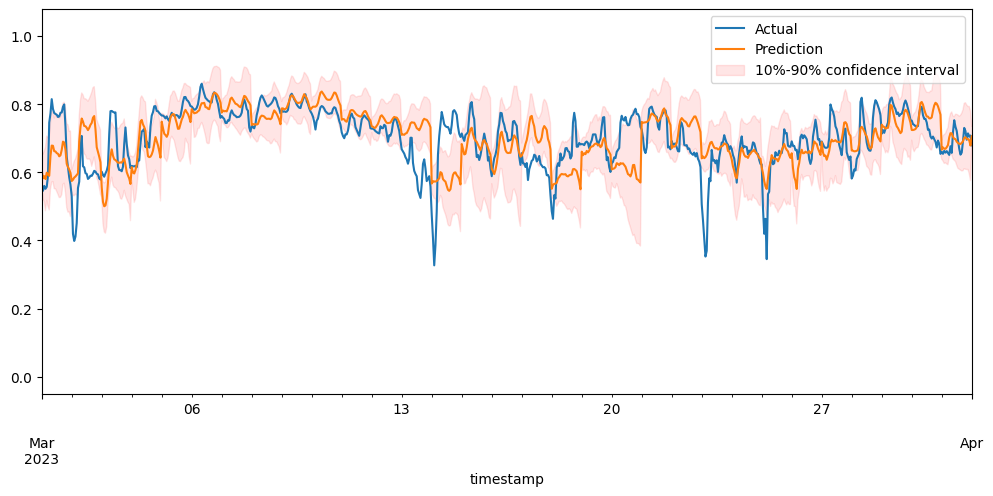

In [23]:
plt.figure(figsize=(12, 5))

y_pred = forecasts.loc[0]
y_test = test.loc[0]

y_test['vwap_log'].plot(label='Actual')
y_pred['mean'].plot(label='Prediction')

plt.fill_between(
  y_pred.index,
  y_pred["0.1"],
  y_pred["0.9"],
  color="red",
  alpha=0.1,
  label=f"10%-90% confidence interval"
)
plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Scaling Back

In [24]:
forecasts['Forecasted VWAP'] = mlog_inv(scaler.inverse_transform(forecasts['mean'].values.reshape(-1, 1)))
forecasts

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2023-01-01 00:00:00  0.453435  0.415901  0.427046  0.436506  0.448226   
        2023-01-01 01:00:00  0.417547  0.359634  0.387714  0.398060  0.406823   
        2023-01-01 02:00:00  0.405060  0.341662  0.366866  0.378086  0.384692   
        2023-01-01 03:00:00  0.391376  0.322966  0.342970  0.360578  0.379841   
        2023-01-01 04:00:00  0.393136  0.305434  0.355660  0.371635  0.383138   
...                               ...       ...       ...       ...       ...   
        2023-12-31 19:00:00  0.718173  0.635622  0.656744  0.675656  0.699443   
        2023-12-31 20:00:00  0.707288  0.621314  0.646613  0.666249  0.684795   
        2023-12-31 21:00:00  0.695984  0.611749  0.633926  0.651423  0.670164   
        2023-12-31 22:00:00  0.684216  0.589390  0.615333  0.645043  0.658547   
        2023-12-31 23:00:00  0.671426  0.572019  0.602196  0.626410  0.648017   

                                  0.5       0.6       0.7       0.8       0.9  \
item_id timestamp                                                               
0       2023-01-01 00:00:00  0.453115  0.458875  0.467700  0.476738  0.493078   
        2023-01-01 01:00:00  0.414773  0.429669  0.439814  0.451497  0.466056   
        2023-01-01 02:00:00  0.402324  0.418388  0.431712  0.447090  0.476180   
        2023-01-01 03:00:00  0.390716  0.407262  0.419282  0.437393  0.461198   
        2023-01-01 04:00:00  0.392919  0.407765  0.428766  0.448076  0.464776   
...                               ...       ...       ...       ...       ...   
        2023-12-31 19:00:00  0.717617  0.733246  0.752522  0.778782  0.805063   
        2023-12-31 20:00:00  0.705603  0.725883  0.742713  0.768134  0.796033   
        2023-12-31 21:00:00  0.692699  0.714504  0.735082  0.762159  0.786662   
        2023-12-31 22:00:00  0.674280  0.699976  0.730316  0.753571  0.786125   
        2023-12-31 23:00:00  0.665561  0.687954  0.714915  0.746988  0.778967   

                             Forecasted VWAP  
item_id timestamp                             
0       2023-01-01 00:00:00         4.726534  
        2023-01-01 01:00:00         2.722799  
        2023-01-01 02:00:00         2.155187  
        2023-01-01 03:00:00         1.597637  
        2023-01-01 04:00:00         1.665825  
...                                      ...  
        2023-12-31 19:00:00        67.752323  
        2023-12-31 20:00:00        61.594958  
        2023-12-31 21:00:00        55.766813  
        2023-12-31 22:00:00        50.257491  
        2023-12-31 23:00:00        44.853525  

[8760 rows x 11 columns]

# Predictions vs Actual Dataset

(466008.0, 466752.0)

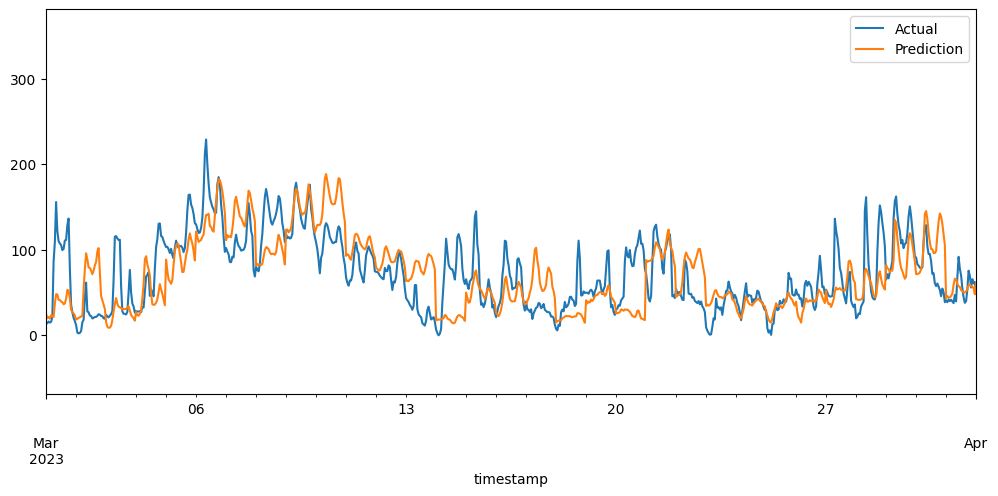

In [26]:
plt.figure(figsize=(12, 5))

actual_prices = intraday_prices(start=end_year, end_incl=end_year)
y_pred = forecasts.loc[0]

actual_prices['vwap'].plot(label='Actual')
y_pred['Forecasted VWAP'].plot(label='Prediction')

plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Evaluation
For simplicity's sake, let's use Darts to evaluate the performance, just to be consistent with other models.

Hack to circumvent error.

Source https://github.com/googlecolab/colabtools/issues/3409

In [27]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [28]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.9 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=f8968c504b4c6365c1549294f33d390eba5e11ff39576161805c674016fb604b
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [29]:
from darts.metrics.metrics import _get_values_or_raise

def wape(actual_series, pred_series):
  y_true, y_hat = _get_values_or_raise(actual_series, pred_series, intersect=True, remove_nan_union=True)
  return 100.0 * np.sum(np.abs(y_true - y_hat)) / np.sum(np.abs(y_true))

In [31]:
from darts import TimeSeries
from darts.metrics import smape, rmse

actual_ts = TimeSeries.from_dataframe(actual_prices)
prediction_ts = TimeSeries.from_series(forecasts.loc[0]['Forecasted VWAP'])

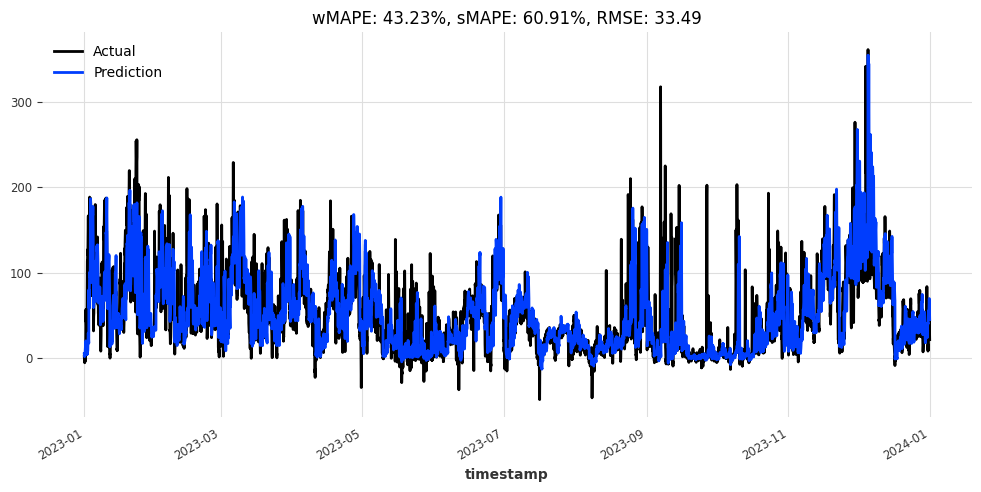

In [33]:
plt.figure(figsize=(12, 5))
actual_ts.plot(label='Actual')
prediction_ts.plot(label='Prediction')

plt.title('wMAPE: {:.2f}%, sMAPE: {:.2f}%, RMSE: {:.2f}'.format(wape(actual_ts, prediction_ts), smape(actual_ts, prediction_ts), rmse(actual_ts, prediction_ts)))
plt.legend()